# Welcome!

Team:

Author(s): Katie Miller, Nathan Tesfayi, Anna Valcarcel

Date(s): August 4-7, 2025




## 1. Setup

Import necessary packages.

In [40]:
import cartopy.crs as ccrs
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean
import seaborn as sns
import cartopy.feature as cfeature
import matplotlib.dates as mdates

[back to top](#Contents)

In [2]:
auth = earthaccess.login(persist=True)

[back to top](#Contents)

## 2. Search for Data

Using 'earthaccess' to search for data. Adjust instrument name as needed. If desired, you can print out the list of available data and their codes using the following:

<code>for item in results:
    summary = item.summary()
    print(summary["short-name"])</code>

In [3]:
results = earthaccess.search_datasets(instrument="oci")

[back to top](#Contents)

## 3. Open L3M Data

We can search earthaccess and specify several parameters including temporal span, variable name, and granule name. 
For granule names, use "DAY" for Daily, "MO" for Monthly, "0p1deg" for 0.1 deg resolution, or "4km" for 4km resolution. The date format is YYYY-MM-DD, with the earlier date first.

In [8]:
# Define search criteria
tspan = ("2024-05-01", "2025-05-30")
var_code = "PACE_OCI_L3M_IOP"
granule_name = "*.DAY.IOP*adg_442*4km*" # Change this for each variable and dataset (IOP, CHL, BGC, AOP,etc.)

results = earthaccess.search_data(
    short_name=var_code,
    temporal=tspan,
    granule_name=granule_name,
    )

paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/357 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/357 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/357 [00:00<?, ?it/s]

In [9]:
# Checke the number of files loaded from search
len(paths)

357

From tutorial:

Because the L3M variables have lat and lon coordinates, it's possible to stack multiple granules along a new dimension that corresponds to time. Instead of `xr.open_dataset`, we can use` xr.open_mfdataset` to create a single `xarray.Dataset` (the "mf" in open_mfdataset stands for multiple files) from an array of paths.

The paths list is sorted temporally by default, which means the shape of the paths array specifies the way we need to tile the files together into larger arrays. We specify combine="nested" to combine the files according to the shape of the array of files (or file-like objects), even though paths is not a "nested" list in this case. The concat_dim="date" argument generates a new dimension in the combined dataset, because "date" is not an existing dimension in the individual files.

In [60]:
dataset = xr.open_mfdataset(
    paths,
    preprocess=time_from_attr,
    combine="nested",
    concat_dim="date",
)
dataset

<xarray.Dataset> Size: 53GB
Dimensions:  (date: 357, lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * date     (date) datetime64[ns] 3kB 2024-05-01T00:24:54 ... 2025-05-01T23:...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    adg_442  (date, lat, lon) float32 53GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (date, rgb, eightbitcolor) uint8 274kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240501.L3m.DAY.IOP.V3_0.adg...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/IOP/3.0
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         2802557
    data_minimum:                      -0.77660006
    data_maximum:                      5.000001

In [53]:
# Drop unnecessary variables
var_data = dataset.drop_vars(["palette"])

# 4. Plot Region

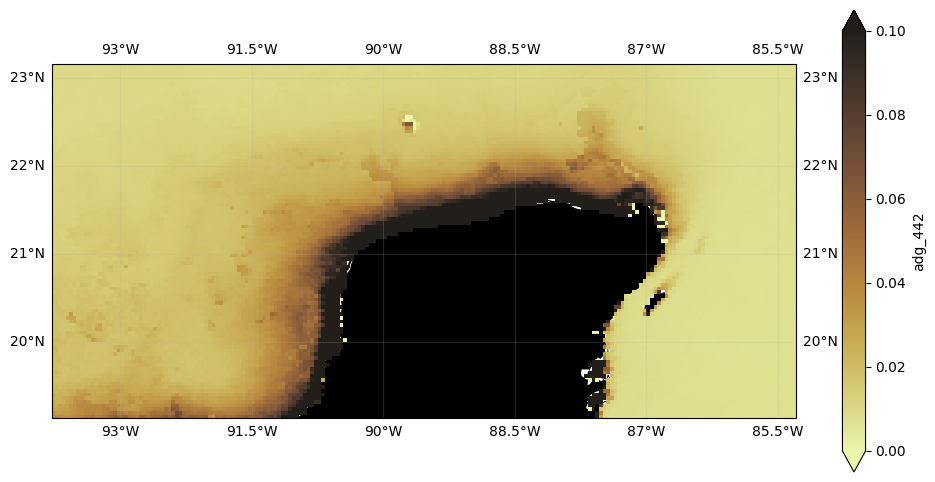

In [38]:
# Define your bounding box
lon_min = -93.779722
lat_min = 19.128302
lon_max = -85.294619
lat_max = 23.164351

# Take average over time and "slice" the global file to the region of interest
var_avg = var_data.mean("date", keep_attrs=True)
var_slice = var_avg.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))

# Plot the variable
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data with correct transform and axis
var_slice.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # your data is in lat/lon
    cmap="cmo.turbid",
    vmin=0, # Change based on scale of your variable
    vmax=0.1,
    cbar_kwargs={'label': 'adg_442'}
)

# Set the map extent to your bounding box
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add filled land
ax.add_feature(cfeature.LAND, facecolor='black')

# Add gridlines with labels
ax.gridlines(draw_labels=True,alpha=0.2)

plt.show()

# 5. Plot Timeseries

## Daily Timeseries

In [64]:
# Take the mean and std dev over the region instead of all dates
region_mean = var_slice.mean(dim=["lat", "lon"])
region_std = var_slice.std(dim=["lat", "lon"])

In [65]:
region_mean.load()
region_std.load()

<xarray.Dataset> Size: 4kB
Dimensions:  (date: 357)
Coordinates:
  * date     (date) datetime64[ns] 3kB 2024-05-01T00:24:54 ... 2025-05-01T23:...
Data variables:
    adg_442  (date) float32 1kB 0.001407 nan 0.007561 ... 0.0004191 0.03681 nan

In [73]:
# Define variable name
var_name = "adg_442"

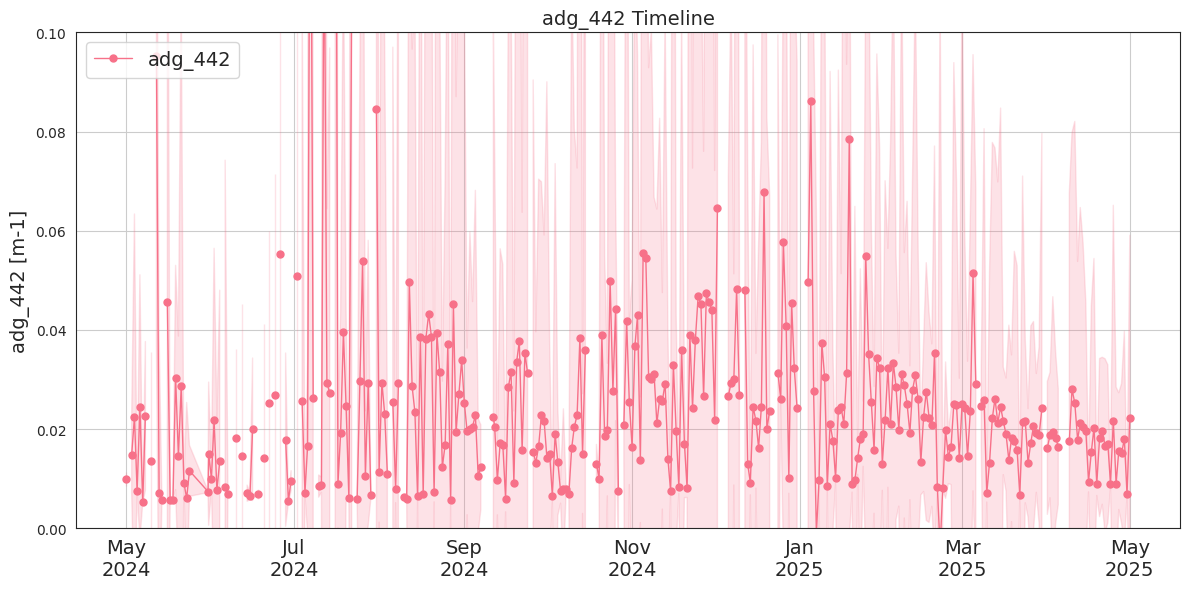

In [78]:
# Plot the timeseries of the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Style
linewidth = 1
markersize = 5
marker = "o"
sns.set_style("white")
palette = sns.color_palette("husl", 3)

# Format the date labels
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

# Left y-axis plots
ax1.plot(
    region_mean[var_name].coords["date"],
    region_mean[var_name],
    color=palette[0],
    marker=marker,
    label=var_name,
    linewidth=linewidth,
    markersize=markersize,
)
ax1.fill_between(
    region_mean[var_name].coords["date"],
    region_mean[var_name] - region_std[var_name],
    region_mean[var_name] + region_std[var_name],
    color=palette[0],
    alpha=0.2,
)

ax1.legend(loc="upper left",fontsize=14)

ax1.set_ylabel(var_name + " [m-1]",fontsize=14) # Change based on variable and units of measurement
plt.xticks(fontsize=14)
ax1.grid()
ax1.set_ylim([0, 0.1])

plt.title(var_name + " Timeline",fontsize=14)
plt.tight_layout()
plt.show()

## Monthly-Average Timeseries

In [68]:
monthly_means = region_mean.groupby("date.month").mean()
monthly_stds = region_std.groupby("date.month").mean()

monthly_stds.load()
monthly_means.load()

<xarray.Dataset> Size: 144B
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    adg_442  (month) float32 48B 0.02704 0.02197 0.02075 ... 0.03048 0.03137

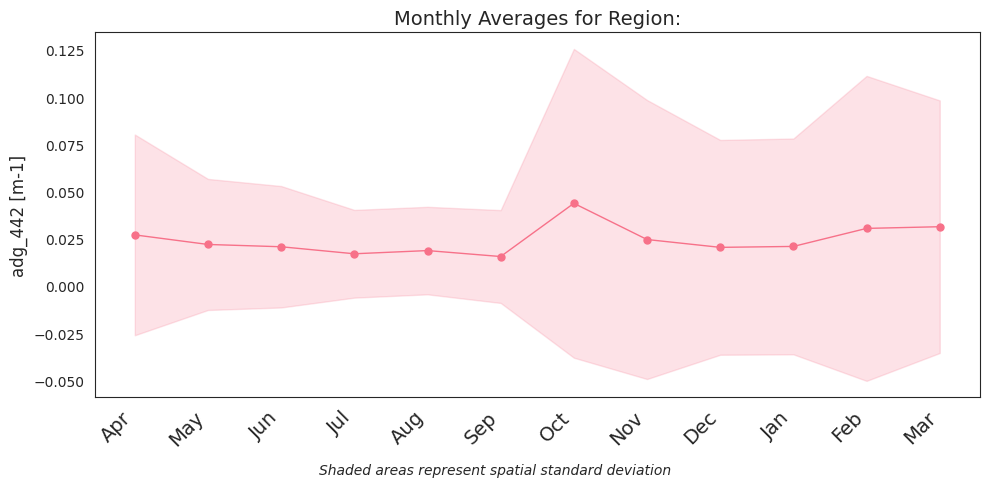

In [79]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 5
sns.set_style("white")
palette = sns.color_palette("husl", 3)

months = monthly_means["month"].values
month_names = [
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
    "Jan",
    "Feb",
    "Mar",
]  # Manually change if different range

# Left axis
ax1.plot(
    months,
    monthly_means[var_name].values,
    "o-",
    color=palette[0],
    label=var_name,
    linewidth=linewidth,
    markersize=markersize,
)
ax1.fill_between(
    months,
    monthly_means[var_name] - monthly_stds[var_name],
    monthly_means[var_name] + monthly_stds[var_name],
    color=palette[0],
    alpha=0.2,
)


# Add labels, titles and improve x-axis
# ax1.set_xlabel("Month", fontsize=12)
ax1.set_ylabel(var_name + " [m-1]", fontsize=12)
ax1.set_xticks(range(1, 13))  # manually change if different months on x axis
ax1.set_xticklabels(month_names)

# ax1.legend(loc="upper left", frameon=True, framealpha=0.6)

plt.title(f"Monthly Averages for Region:", fontsize=14)
fig.text(
    0.5,
    0.01,
    "Shaded areas represent spatial standard deviation",
    ha="center",
    fontsize=10,
    style="italic",
)

plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")
plt.xticks(fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for the note
plt.show()

[back to top](#Contents)